# Doc2vec

In [1]:
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
from wordfreq import top_n_list
import numpy as np
from nltk.corpus import stopwords
import requests
import requests_random_user_agent
from tqdm.notebook import tqdm
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
def read_corpus(txt, tokens_only=False):
    common_words = top_n_list('en', 100)
    stop_words = stopwords.words('english')
    alphabet = re.compile('[^a-z]')
    for i, line in enumerate(txt):
        tokens = gensim.utils.simple_preprocess(line)
        tokens = [word for word in tokens if word not in common_words]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [alphabet.sub('',word) for word in tokens]
        tokens = stem(tokens)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens[1:], [i])

def stem(words):
    ps = PorterStemmer()
    stemmed = []
    for w in words:
        stemmed.append(ps.stem(w))
    return stemmed

In [20]:
with open('../../data/risk_factor_statements/cyber_risk_sentences/2016_cyber_sentences.txt', "r") as f:
    txt = re.split('=====[^=]+=====\n\n\n',f.read())[:-1]
train_corpus = list(read_corpus(txt))

In [172]:
#print(train_corpus[0])

In [166]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=5)
model.build_vocab(train_corpus)

In [167]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [55]:
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

[-0.02867286 -0.01995462 -0.01142599  0.02895425  0.01551732 -0.06202421
  0.00371301  0.04787116 -0.01677673  0.00309324 -0.00465718 -0.00814196
  0.02484238  0.01047405  0.02521121 -0.02983563 -0.03052537  0.01624445
  0.00199441 -0.05465697 -0.00890239  0.00861912 -0.00346235 -0.00924161
 -0.04487488 -0.01578563 -0.04106465 -0.02089635  0.00692996 -0.03132755
  0.04878104  0.01370774 -0.01862125 -0.00152941 -0.0244432   0.04910767
 -0.00136203 -0.01636801 -0.02725219 -0.02236172 -0.01195841 -0.04637709
  0.02772791 -0.02678827  0.0400826   0.02329716  0.01800618 -0.00681951
  0.01472996 -0.03525409 -0.01135846 -0.00838562  0.01181012 -0.04728112
 -0.00862     0.03311446 -0.00831013  0.0222843  -0.03776633 -0.04361394
  0.0215193   0.03881756  0.07040036 -0.03060826 -0.01407657  0.04174524
  0.00740174 -0.01578724 -0.04481208  0.01000662 -0.00994166  0.01745901
  0.0017734  -0.01549341 -0.00518965 -0.00460535 -0.00739628  0.00295362
 -0.01368114 -0.01209284  0.03516541 -0.01512947 -0

In [57]:
for doc_id in range(len(train_corpus)-3600):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

In [58]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (82): «addit face threat unauthor system access comput hacker comput virus malici code organ cyber attack secur breach system disrupt devot signific resourc secur comput system may still vulner threat result may requir expend signific resourc protect threat system disrupt secur breach allevi problem caus disrupt breach anyon circumv secur measur misappropri proprietari inform caus interrupt malfunct system oper event caus system interrupt delay loss critic data delay prevent oper materi advers effect busi financi condit result oper cash flow neg impact client addit matter discuss risk factor includ herein reason fluctuat stock price includ oper financi perform prospect depth liquid market common stock investor percept industri oper level lack thereof research coverag common stock gener financi domest intern econom market condit propos acquisit competitor hire departur key personnel advers judgment settlement oblig pay damag cautionari statement regard forward look inform addit

In [59]:
vec1 = model.infer_vector(train_corpus[0].words)
vec2 = model.infer_vector(train_corpus[1].words)

cos_distance = spatial.distance.cosine(vec1, vec2)
similarity = 1-abs(cos_distance)
similarity

0.18087194859981537

In [60]:
test_sentences = 'An adversary may abuse configurations where an application has the setuid or setgid bits set in order to get code running in a different (and possibly more privileged) user’s context. On Linux or macOS, when the setuid or setgid bits are set for an application binary, the application will run with the privileges of the owning user or group respectively. Normally an application is run in the current user’s context, regardless of which user or group owns the application. However, there are instances where programs need to be executed in an elevated context to function properly, but the user running them may not have the specific required privileges.'
ts = gensim.utils.simple_preprocess(test_sentences)
test_corpus = gensim.models.doc2vec.TaggedDocument(ts, ['test'])
test_vec = model.infer_vector(test_corpus.words)
vec1 = model.infer_vector(train_corpus[0].words)

cos_distance = spatial.distance.cosine(vec1, test_vec)
similarity = 1-abs(cos_distance)
similarity

0.3567906320095062

In [61]:
' '.join(train_corpus[9].words)

'cyber relat sentenc'

In [62]:
with open('../../data/risk_factor_statements/cyber_risk_sentences/2016_cyber_sentences.txt', "r") as f:
    txt = re.split('=====[^=]+=====\n\n\n',f.read())[:-1]

sim = []
for line in txt[:1][0].split('.'):
    line = gensim.utils.simple_preprocess(line)
    line = gensim.models.doc2vec.TaggedDocument(line, ['l'])
    vec1 = model.infer_vector(line.words)
    cos_distance = spatial.distance.cosine(vec1, test_vec)
    similarity = 1-abs(cos_distance)
    print(' '.join(line.words))
    print(similarity)
    sim.append(similarity)
print(np.mean(sim))

tsla although we take steps to protect the security of our customers personal information we may be required to expend significant resources to comply with data breach requirements if third parties improperly obtain and use the personal information of our customers or we otherwise experience data loss with respect to customers personal information
0.19156083464622498
major breach of our network security and systems could have negative consequences for our business and future prospects including possible fines penalties and damages reduced customer demand for our vehicles and harm to our reputation and brand
0.3249022662639618
we are currently expanding and improving our information technology systems and use security measures designed to protect our systems against breaches and cyber attacks
0.23939917981624603
we also maintain information technology measures designed to protect us against system security risks data breaches and cyber attacks
0.2700885236263275
we have designed impleme

In [63]:
not_cyber_sentence = 'The commercial production of fully electric vehicles that meets consumers’ range and performance expectations requires substantial design, engineering, and integration work on almost every system of our vehicles.'
nc = gensim.utils.simple_preprocess(not_cyber_sentence)
nc = gensim.models.doc2vec.TaggedDocument(nc, ['nc'])
vec1 = model.infer_vector(nc.words)

cos_distance = spatial.distance.cosine(vec1, test_vec)
similarity = 1-abs(cos_distance)
similarity

0.19303855299949646

In [64]:
def get_vect(gensim, model, sentence, tag):
    sentence = gensim.utils.simple_preprocess(sentence)
    sentence = gensim.models.doc2vec.TaggedDocument(sentence, [tag])
    
    return model.infer_vector(sentence.words)

In [65]:
sentence0 = 'The commercial production of fully electric vehicles that meets consumers’ range and performance expectations requires substantial design, engineering, and integration work on almost every system of our vehicles.'
sentence1 = 'Since the first quarter of 2020, there has been a worldwide impact from the COVID-19 pandemic. Government regulations and shifting social behaviors have, at times, limited or closed non-essential transportation, government functions, business activities and person-to-person interactions. Global trade conditions and consumer trends that originated during the pandemic continue to persist and may also have long-lasting adverse impact on us and our industries independently of the progress of the pandemic.'
sentence2 = 'Our products contain thousands of parts purchased globally from hundreds of suppliers, including single-source direct suppliers, which exposes us to multiple potential sources of component shortages.'
sentence3 = 'Cost of automotive leasing revenue increased $531 million, or 54%, in the year ended December 31, 2022 as compared to the year ended December 31, 2021, primarily due to an increase in cumulative vehicles under our direct operating lease program and an increase in direct sales-type leasing cost of revenues from more activities in the current year.'

sentence4 = 'major breach of our network security and systems could have negative consequences for our business and future prospects including possible fines penalties and damages reduced customer demand for our vehicles and harm to our reputation and brand'
sentence5 = 'There may be losses or unauthorized access to or releases of confidential information, including personally identifiable information, that could subject the Company to significant reputational, financial, legal and operational consequences.'

sentence6 = 'An adversary may abuse configurations where an application has the setuid or setgid bits set in order to get code running in a different (and possibly more privileged) user’s context. On Linux or macOS, when the setuid or setgid bits are set for an application binary, the application will run with the privileges of the owning user or group respectively. Normally an application is run in the current user’s context, regardless of which user or group owns the application. However, there are instances where programs need to be executed in an elevated context to function properly, but the user running them may not have the specific required privileges.'
sentence7 = 'An adversary may compress and/or encrypt data that is collected prior to exfiltration. Compressing the data can help to obfuscate the collected data and minimize the amount of data sent over the network. Encryption can be used to hide information that is being exfiltrated from detection or make exfiltration less conspicuous upon inspection by a defender.'

vec = []
vec.append(get_vect(gensim, model, sentence0, 1000))
vec.append(get_vect(gensim, model, sentence1, 1001))
vec.append(get_vect(gensim, model, sentence2, 1002))
vec.append(get_vect(gensim, model, sentence3, 1003))
vec.append(get_vect(gensim, model, sentence4, 1004))
vec.append(get_vect(gensim, model, sentence5, 1005))
vec.append(get_vect(gensim, model, sentence6, 1006))
vec.append(get_vect(gensim, model, sentence7, 1007))

In [72]:
sim = []
for i in range(len(vec)):
    for j in range(len(vec)):
        if i <= j:
            sim.append(np.nan)
            continue
        cos_distance = spatial.distance.cosine(vec[i], vec[j])
        print(cos_distance)
        similarity = 1-cos_distance
        sim.append(similarity)
idx = ['Not cyber 1', 'Not cyber 2', ' Not cyber 3',' Not cyber 4',
       'Cyber 1', 'Cyber 2',
       'Cyber reference 1', 'Cyber reference 2']
df = pd.DataFrame(np.array(sim).reshape(len(vec),-1), index = idx, columns = idx)
df

1.4088575541973114
0.3565194010734558
1.29591703414917
1.5024864077568054
0.7429663240909576
1.3437986373901367
0.35930877923965454
1.3628029525279999
0.3079606294631958
1.475574642419815
0.3134387135505676
1.2935063540935516
0.32338130474090576
1.5467024445533752
0.23748254776000977
0.7028325796127319
1.2029985785484314
0.6227596700191498
0.9035193398594856
0.6113878786563873
0.7283049523830414
0.5454630851745605
1.2684800624847412
0.5532598793506622
1.213698297739029
0.36849445104599
0.536853164434433
0.5553803741931915


,Not cyber 1,Not cyber 2,Not cyber 3,Not cyber 4,Cyber 1,Cyber 2,Cyber reference 1,Cyber reference 2
Not cyber 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Not cyber 2,-0.408858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Not cyber 3,0.643481,-0.295917,NaN,NaN,NaN,NaN,NaN,NaN
Not cyber 4,-0.502486,0.257034,-0.343799,NaN,NaN,NaN,NaN,NaN
Cyber 1,0.640691,-0.362803,0.692039,-0.475575,NaN,NaN,NaN,NaN
Cyber 2,0.686561,-0.293506,0.676619,-0.546702,0.762517,NaN,NaN,NaN
Cyber reference 1,0.297167,-0.202999,0.377240,0.096481,0.388612,0.271695,NaN,NaN
Cyber reference 2,0.454537,-0.268480,0.446740,-0.213698,0.631506,0.463147,0.44462,NaN


In [67]:
df.T.filter(like = 'reference').mean(1).iloc[:-2]

Not cyber 1     0.375852
Not cyber 2    -0.235739
 Not cyber 3    0.411990
 Not cyber 4   -0.058609
Cyber 1         0.510059
Cyber 2         0.367421
dtype: float64

## Try training model with whole 10-ks + MITRE

In [2]:
stocknames = pd.read_csv("../../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)

In [3]:
def get_tokens(text, raw = True):
    if(raw):
        document = get_text(text)
    else:
        document = text
    
    document = re.sub('\n',' ', document)
    document = re.sub('\s{2,}',' ', document)
    lines = sent_tokenize(document)
    lines = [line for line in lines if len(word_tokenize(line)) > 15]
    
    tokens_per_line = []
    for line in lines:
        tokens = gensim.utils.simple_preprocess(line)
        tokens = [word for word in tokens if word not in common_words]
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [alphabet.sub('',word) for word in tokens]
        tokens = stem(tokens)
        tokens_per_line.append(tokens)
        
    return tokens_per_line

def get_vect(gensim, model, sentence, tag):
    sentence = get_tokens(sentence, raw = False)[0]
    sentence = gensim.models.doc2vec.TaggedDocument(sentence, [tag])
    model.random.seed(0)
    
    return model.infer_vector(sentence.words)

def stem(words):
    ps = PorterStemmer()
    stemmed = []
    for w in words:
        stemmed.append(ps.stem(w))
    return stemmed

def get_text(raw_text):
    #Regex to find <DOCUMENT> tags
    document_start_pattern = re.compile(r'<DOCUMENT>')
    document_end_pattern = re.compile(r'</DOCUMENT>')
    # Regex to find <TYPE> tag preceeding any characters until the end of the line
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    document_starts = [start_pattern.end() for start_pattern in document_start_pattern.finditer(text)]
    document_ends = [end_pattern.start() for end_pattern in document_end_pattern.finditer(text)]
    # find the type of each part of the raw text file
    document_types = [type_[len('<TYPE>'):] for type_ in type_pattern.findall(raw_text)]
    # Loop through the sections of the document and save the 10-k part
    document = []
    for document_type, document_start, document_end in zip(document_types, document_starts, document_ends):
        if document_type == '10-K' or document_type == '10-K/A':
            #only retain the first occurance
            if not len(document):
                document = text[document_start:document_end]
    soup = BeautifulSoup(document, "html.parser")
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    document = soup.get_text()
    return document

In [331]:
urls = np.squeeze(stocknames.sample(1500, random_state = 1).filter(like = 'url').iloc[:,:2].values.reshape(-1,1))
urls = [url for url in urls if url is not np.nan]
print('Nb urls:', len(urls))

common_words = top_n_list('en', 100)
stop_words = stopwords.words('english')
alphabet = re.compile('[^a-z]')

allpromises = []
delayed_tokens = dask.delayed(get_tokens)
for url in tqdm(urls):
    text = requests.get(url).text
    allpromises.append(delayed_tokens(text))

with TqdmCallback(desc = 'Tokenizing 10-Ks'):
    temp = dask.compute(allpromises)[0]

tagged_tokens = []
tag_links = []
for i, tokens_per_line in enumerate(temp):
    for j, tokens in enumerate(tokens_per_line):
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['10k{}_{}'.format(i,j)]))
        tag_links.append('10k{}_{}'.format(i,j))
    
    #ADD MITRE
techniques = pd.read_csv('../data/MITRE_ATT&CK/descriptions/techniques.csv', index_col = [0,1])
for k,technique in enumerate(tqdm(techniques.Description.values)):
    tokens_per_line = get_tokens(technique, raw = False)
    for l, tokens in enumerate(tokens_per_line):
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['tec{}_{}'.format(j,l)]))
        tag_links.append('tec{}_{}'.format(j,l))

tactics = pd.read_csv('../data/MITRE_ATT&CK/descriptions/techniques.csv', index_col = [0,1])
for k,technique in enumerate(tqdm(techniques.Description.values)):
    tokens_per_line = get_tokens(technique, raw = False)
    for l, tokens in enumerate(tokens_per_line):
        tagged_tokens.append(gensim.models.doc2vec.TaggedDocument(tokens, ['tec{}_{}'.format(j,l)]))
        tag_links.append('tec{}_{}'.format(j,l))

print('Nb training sentences: {}'.format(len(tagged_tokens)))

Nb urls: 1070


  0%|          | 0/1070 [00:00<?, ?it/s]

Tokenizing 10-Ks:   0%|          | 0/1070 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Nb training sentences:


In [335]:
import logging
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

In [336]:
model = gensim.models.doc2vec.Doc2Vec(vector_size = 100, min_count = 5, epochs = 10)
model.build_vocab(tagged_tokens)

2023-04-05 15:26:33,947 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc5,s0.001,t3)', 'datetime': '2023-04-05T15:26:33.947724', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-04-05 15:26:33,951 : INFO : collecting all words and their counts
2023-04-05 15:26:33,952 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-04-05 15:26:33,999 : INFO : PROGRESS: at example #10000, processed 190534 words (4144877/s), 1846 word types, 10000 tags
2023-04-05 15:26:34,045 : INFO : PROGRESS: at example #20000, processed 381420 words (4195116/s), 1846 word types, 20000 tags
2023-04-05 15:26:34,084 : INFO : PROGRESS: at example #30000, processed 574077 words (5157600/s), 1846 word types, 30000 tags
2023-04-05 15:26:34,122 : INFO : PROGRESS: at example #40000, processed 764460 words (5104319/s), 1846 word types, 40000 tags
2023-04-05 15:26:

2023-04-05 15:26:36,430 : INFO : PROGRESS: at example #610000, processed 11675569 words (5005076/s), 1846 word types, 610000 tags
2023-04-05 15:26:36,470 : INFO : PROGRESS: at example #620000, processed 11866298 words (4952493/s), 1846 word types, 620000 tags
2023-04-05 15:26:36,511 : INFO : PROGRESS: at example #630000, processed 12058852 words (4817513/s), 1846 word types, 630000 tags
2023-04-05 15:26:36,547 : INFO : PROGRESS: at example #640000, processed 12249122 words (5404932/s), 1846 word types, 640000 tags
2023-04-05 15:26:36,586 : INFO : PROGRESS: at example #650000, processed 12440175 words (4914865/s), 1846 word types, 650000 tags
2023-04-05 15:26:36,626 : INFO : PROGRESS: at example #660000, processed 12632687 words (4928401/s), 1846 word types, 660000 tags
2023-04-05 15:26:36,666 : INFO : PROGRESS: at example #670000, processed 12823387 words (4948596/s), 1846 word types, 670000 tags
2023-04-05 15:26:36,703 : INFO : PROGRESS: at example #680000, processed 13015877 words (5

2023-04-05 15:26:45,585 : INFO : estimated required memory for 2110 words and 100 dimensions: 685834600 bytes
2023-04-05 15:26:45,586 : INFO : resetting layer weights
2023-04-05 15:26:46,084 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 2110 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-04-05T15:26:46.084896', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
2023-04-05 15:26:47,103 : INFO : EPOCH 1 - PROGRESS: at 2.24% examples, 443949 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:26:48,135 : INFO : EPOCH 1 - PROGRESS: at 4.52% examples, 443829 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:26:49,141 : INFO : EPOCH 1 - PROGRESS: at 6.86% examples, 451126 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:26:50,151 : INFO : EPOCH 1 - PROGRESS: at 9.15% examples, 451869 words/s, in_qsize 5, o

2023-04-05 15:27:52,744 : INFO : EPOCH 2 - PROGRESS: at 51.17% examples, 460484 words/s, in_qsize 6, out_qsize 1
2023-04-05 15:27:53,753 : INFO : EPOCH 2 - PROGRESS: at 53.59% examples, 461438 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:27:54,758 : INFO : EPOCH 2 - PROGRESS: at 56.00% examples, 462367 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:27:55,759 : INFO : EPOCH 2 - PROGRESS: at 58.39% examples, 462944 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:27:56,785 : INFO : EPOCH 2 - PROGRESS: at 60.76% examples, 463022 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:27:57,817 : INFO : EPOCH 2 - PROGRESS: at 63.19% examples, 463353 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:27:58,830 : INFO : EPOCH 2 - PROGRESS: at 65.61% examples, 463961 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:27:59,852 : INFO : EPOCH 2 - PROGRESS: at 68.03% examples, 464377 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:28:00,852 : INFO : EPOCH 2 - PROGRESS: at 70.37% examples, 464482 words/s, in_qsiz

2023-04-05 15:29:00,836 : INFO : EPOCH 4 - PROGRESS: at 10.93% examples, 436780 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:01,845 : INFO : EPOCH 4 - PROGRESS: at 13.31% examples, 442911 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:29:02,850 : INFO : EPOCH 4 - PROGRESS: at 15.73% examples, 448843 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:03,862 : INFO : EPOCH 4 - PROGRESS: at 18.11% examples, 451694 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:04,902 : INFO : EPOCH 4 - PROGRESS: at 20.58% examples, 454573 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:05,907 : INFO : EPOCH 4 - PROGRESS: at 23.00% examples, 457495 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:06,925 : INFO : EPOCH 4 - PROGRESS: at 25.42% examples, 459363 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:29:07,935 : INFO : EPOCH 4 - PROGRESS: at 27.80% examples, 460448 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:29:08,943 : INFO : EPOCH 4 - PROGRESS: at 30.13% examples, 460755 words/s, in_qsiz

2023-04-05 15:30:11,593 : INFO : EPOCH 5 - PROGRESS: at 73.38% examples, 453524 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:12,618 : INFO : EPOCH 5 - PROGRESS: at 75.76% examples, 453899 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:13,641 : INFO : EPOCH 5 - PROGRESS: at 78.18% examples, 454545 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:14,645 : INFO : EPOCH 5 - PROGRESS: at 80.56% examples, 455110 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:15,658 : INFO : EPOCH 5 - PROGRESS: at 82.94% examples, 455575 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:30:16,659 : INFO : EPOCH 5 - PROGRESS: at 85.31% examples, 456132 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:17,667 : INFO : EPOCH 5 - PROGRESS: at 87.69% examples, 456595 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:30:18,688 : INFO : EPOCH 5 - PROGRESS: at 90.11% examples, 457098 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:30:19,709 : INFO : EPOCH 5 - PROGRESS: at 92.54% examples, 457577 words/s, in_qsiz

2023-04-05 15:31:19,117 : INFO : EPOCH 7 - PROGRESS: at 21.76% examples, 430669 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:31:20,139 : INFO : EPOCH 7 - PROGRESS: at 24.05% examples, 432353 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:31:21,161 : INFO : EPOCH 7 - PROGRESS: at 26.38% examples, 434502 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:31:22,165 : INFO : EPOCH 7 - PROGRESS: at 28.72% examples, 436922 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:31:23,206 : INFO : EPOCH 7 - PROGRESS: at 31.00% examples, 437183 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:31:24,226 : INFO : EPOCH 7 - PROGRESS: at 33.38% examples, 439250 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:31:25,227 : INFO : EPOCH 7 - PROGRESS: at 35.66% examples, 440446 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:31:26,234 : INFO : EPOCH 7 - PROGRESS: at 37.86% examples, 440299 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:31:27,260 : INFO : EPOCH 7 - PROGRESS: at 40.14% examples, 440678 words/s, in_qsiz

2023-04-05 15:32:29,608 : INFO : EPOCH 8 - PROGRESS: at 79.55% examples, 450627 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:30,633 : INFO : EPOCH 8 - PROGRESS: at 81.97% examples, 451304 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:31,639 : INFO : EPOCH 8 - PROGRESS: at 84.17% examples, 450941 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:32,656 : INFO : EPOCH 8 - PROGRESS: at 86.50% examples, 451187 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:33,658 : INFO : EPOCH 8 - PROGRESS: at 88.88% examples, 451815 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:34,659 : INFO : EPOCH 8 - PROGRESS: at 91.26% examples, 452446 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:35,668 : INFO : EPOCH 8 - PROGRESS: at 93.63% examples, 452946 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:36,673 : INFO : EPOCH 8 - PROGRESS: at 96.01% examples, 453462 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:32:37,676 : INFO : EPOCH 8 - PROGRESS: at 98.38% examples, 453976 words/s, in_qsiz

2023-04-05 15:33:37,495 : INFO : EPOCH 10 - PROGRESS: at 34.75% examples, 460412 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:38,496 : INFO : EPOCH 10 - PROGRESS: at 37.09% examples, 460872 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:39,514 : INFO : EPOCH 10 - PROGRESS: at 39.41% examples, 460771 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:40,515 : INFO : EPOCH 10 - PROGRESS: at 41.66% examples, 460172 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:41,527 : INFO : EPOCH 10 - PROGRESS: at 44.03% examples, 460775 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:33:42,533 : INFO : EPOCH 10 - PROGRESS: at 46.36% examples, 461016 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:43,543 : INFO : EPOCH 10 - PROGRESS: at 48.69% examples, 461141 words/s, in_qsize 5, out_qsize 0
2023-04-05 15:33:44,565 : INFO : EPOCH 10 - PROGRESS: at 51.07% examples, 461402 words/s, in_qsize 6, out_qsize 0
2023-04-05 15:33:45,582 : INFO : EPOCH 10 - PROGRESS: at 53.49% examples, 462127 words/s

In [ ]:
model.train(tagged_tokens, total_examples = model.corpus_count, epochs = model.epochs)

In [531]:
cd Doc2vec

/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec


In [538]:
from gensim.test.utils import datapath
path = datapath('/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model')
model.save(path)

2023-04-06 16:33:54,279 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-06T16:33:54.279710', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
2023-04-06 16:33:54,282 : INFO : storing np array 'vectors' to /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model.dv.vectors.npy
2023-04-06 16:33:55,670 : INFO : saved /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model


In [539]:
model2 = gensim.models.doc2vec.Doc2Vec.load(path)

2023-04-06 16:34:24,281 : INFO : loading Doc2Vec object from /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model
2023-04-06 16:34:24,667 : INFO : loading dv recursively from /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model.dv.* with mmap=None
2023-04-06 16:34:24,668 : INFO : loading vectors from /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model.dv.vectors.npy with mmap=None
2023-04-06 16:34:24,865 : INFO : loading wv recursively from /Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model.wv.* with mmap=None
2023-04-06 16:34:24,882 : INFO : Doc2Vec lifecycle event {'fname': '/Users/danielceleny/Documents/Cyberisk_price/models/Doc2vec/model', 'datetime': '2023-04-06T16:34:24.882566', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 18:29:29) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [540]:
#AAPL 2021   META 2021
url = stocknames[stocknames.ticker == 'META'].filter(like = 'url_2021').values[0][0]

text = requests.get(url).text
document = get_text(text)
document = re.sub('\n',' ', document)
document = re.sub('\s{2,}',' ',document)
lines = sent_tokenize(document)
lines = [line for line in lines if len(word_tokenize(line)) > 15]
inferred_vector = []
for j, technique in enumerate(techniques.Description.values):
    technique = [sentence for sentence in sent_tokenize(technique) if len(word_tokenize(sentence)) > 15]
    technique = ' '.join(technique)
    if not len(technique):
        continue
    inferred_vector.append(get_vect(gensim, model2, technique, 'tec_t{}'.format(j)))

sim = []
for i,line in enumerate(tqdm(lines)):
    line = get_tokens(line, raw = False)
    line = gensim.models.doc2vec.TaggedDocument(line, ['line{}'.format(i)])
    model2.random.seed(0)
    vec1 = model2.infer_vector(line.words[0])
    similarity = []
    for iv in inferred_vector:
        similarity.append(max(cosine_similarity([vec1],[iv])[0][0],0))
    sim.append(similarity)
print('mean: {}'.format(np.mean(sim)))
print('max: {}'.format(np.max(sim)))
mean = np.mean(sim,1)
print('50,75,90,99 percentiles: {}'.format(np.percentile(mean, [50, 75, 90, 95])))
print('mean above 90 percentile: {}'.format(np.mean(mean[mean>np.percentile(mean, 90)])))

  0%|          | 0/1243 [00:00<?, ?it/s]

mean: 0.11439835838140072
max: 0.9800457954406738
50,75,90,99 percentiles: [0.07736947 0.15537854 0.28558225 0.34437617]
mean above 90 percentile: 0.3480855513511762


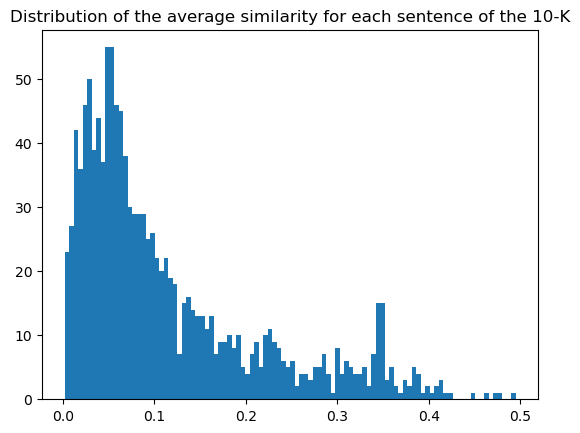

In [541]:
plt.hist(np.mean(sim,1), bins = 100)
plt.title('Distribution of the average similarity for each sentence of the 10-K')
plt.show()

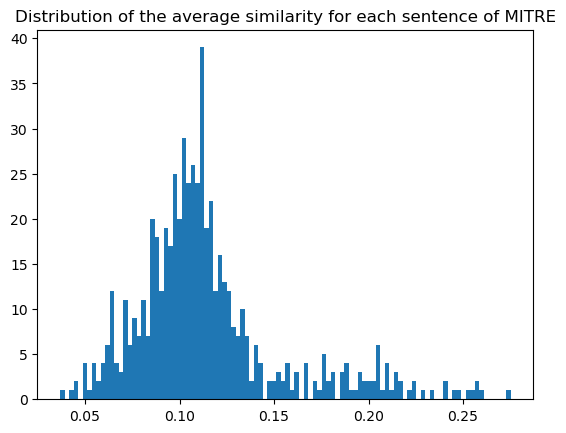

In [542]:
plt.hist(np.mean(sim,0), bins = 100)
plt.title('Distribution of the average similarity for each sentence of MITRE')
plt.show()

In [543]:
for idx in reversed(np.argsort(np.mean(sim,1))[-10:]):
    print(np.mean(sim,1)[idx])
    print('tec_{}'.format(np.argmax(sim,1)[idx]))
    print(lines[idx])

0.4948816346225597
tec_369
In addition, computer malware, viruses, social engineering (predominantly spear phishing attacks), scraping, and general hacking have become more prevalent in our industry, have occurred on our systems in the past, and will occur on our systems in the future.
0.47900178588263814
tec_58
Some errors, bugs, or vulnerabilities inherently may be difficult to detect and may only be discovered after the code has been released for external or internal use.
0.4735565423712892
tec_58
In addition, certain of our users can use our Payments infrastructure, including on Messenger and WhatsApp, for other activities, such as sending money to other users and making donations to certain charitable organizations.
0.4645246611055681
tec_405
For example, in September 2018, we announced our discovery of a third-party cyber-attack that exploited a vulnerability in Facebook's code to steal user access tokens and access certain profile information from user accounts on Facebook.
0.45

In [516]:
for idx in np.argsort(np.mean(sim,1))[:10]:
    print(np.mean(sim,1)[idx])
    print('tec_{}'.format(np.argmin(sim,1)[idx]))
    print(lines[idx])

0.0018716566043637567
tec_0
If the IRS prevails in its position, it could result in an additional federal tax liability, plus interest and any penalties asserted.
0.002111550392109459
tec_0
We classify our marketable securities as available-for-sale (AFS) investments in our current assets because they represent investments of cash available for current operations.
0.0023696383650777704
tec_0
The consolidated statements of income data for the years ended December 31, 2017 and 2016 and the consolidated balance sheets data as of December 31, 2018, 2017, and 2016 are derived from our audited consolidated financial statements, except as otherwise noted, that are not included in this Annual Report on Form 10-K. Our historical results are not necessarily indicative of our results in any future period.
0.002994370166906866
tec_0
Share-based Compensation PlansIn 2020, we maintained one active share-based employee compensation plan, the 2012 Equity Incentive Plan, which was amended in each of Ju

In [517]:
@dask.delayed()
def get_sim(vec1,inferred_vector):    
    similarity = []
    for iv in inferred_vector:
        similarity.append(max(cosine_similarity([vec1],[iv])[0][0],0))
    return similarity

In [518]:
urls2 = stocknames.sample(50, random_state = 22).filter(like = 'url')
years = np.arange(2007,2023)
                   
inferred_vector = []
for j, technique in enumerate(techniques.Description.values):
    technique = [sentence for sentence in sent_tokenize(technique) if len(word_tokenize(sentence)) > 15]
    technique = ' '.join(technique)
    if not len(technique):
        continue
    inferred_vector.append(get_vect(gensim, model, technique, 'tec_t{}'.format(j)))

to_plot = {}
for year in years:
    urls3 = np.squeeze(urls2.filter(like = str(year)).dropna().values)
    to_plot[year] = []
    for url in tqdm(urls3, desc = 'Evaluating firms for {}'.format(year), leave = False):  
        text = requests.get(url).text
        document = get_text(text)
        document = re.sub('\n',' ', document)
        document = re.sub('\s{2,}',' ',document)
        lines = sent_tokenize(document)
        lines = [line for line in lines if len(word_tokenize(line)) > 15]

        allpromises = []
        for i,line in enumerate(lines):
            line = get_tokens(line, raw = False)
            line = gensim.models.doc2vec.TaggedDocument(line, ['line{}'.format(i)])
            model.random.seed(0)
            vec1 = model.infer_vector(line.words[0])
            allpromises.append(get_sim(vec1,inferred_vector))
            
        with TqdmCallback(desc = 'Comparing lines', leave=False):
            sim = dask.compute(allpromises)[0]           
        mean = np.mean(sim,1)
        to_plot[year].append([np.mean(sim),
                              np.max(sim),
                              np.percentile(mean, 50),
                              np.percentile(mean, 75),
                              np.percentile(mean, 90),
                              np.percentile(mean, 95),
                              np.mean(mean[mean>np.percentile(mean, 90)])])

Evaluating firms for 2007:   0%|          | 0/31 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1075 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1205 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1003 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1435 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/248 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/932 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/738 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1827 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1593 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1010 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1341 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/856 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/2121 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1347 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1622 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1345 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1161 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/927 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/448 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1899 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1380 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/665 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1397 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1474 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1375 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1035 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1358 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1179 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1448 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1290 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1134 [00:00<?, ?it/s]

Evaluating firms for 2008:   0%|          | 0/28 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/999 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1197 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1037 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1498 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1070 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/820 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1559 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1806 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/973 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/860 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1337 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1341 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1801 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1175 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1221 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/976 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/464 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1706 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1389 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/632 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1438 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1981 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1512 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/996 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1403 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1269 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1623 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1367 [00:00<?, ?it/s]

Evaluating firms for 2009:   0%|          | 0/28 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1067 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1605 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1070 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1555 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1210 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1448 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1612 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/959 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/882 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1457 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1601 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1734 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1255 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1817 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1028 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1160 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1756 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1585 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/640 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1463 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/2065 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1630 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/587 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/900 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1505 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1285 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1517 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1409 [00:00<?, ?it/s]

Evaluating firms for 2010:   0%|          | 0/25 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1260 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1740 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1295 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/4534 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1284 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1359 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1618 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/915 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/846 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1554 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1786 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1242 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/958 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1554 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1820 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1487 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/704 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1430 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/2118 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1381 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/593 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1155 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1320 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1600 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1346 [00:00<?, ?it/s]

Evaluating firms for 2011:   0%|          | 0/28 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1369 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1705 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1291 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/4050 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1440 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1330 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1535 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1027 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1313 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/820 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1625 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1508 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1287 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/947 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1574 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1965 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1281 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/734 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1502 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/2578 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1518 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/660 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/913 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1871 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/903 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1182 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1703 [00:00<?, ?it/s]

Comparing lines:   0%|          | 0/1312 [00:00<?, ?it/s]

Evaluating firms for 2012:   0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [519]:
to_plot_df = []
for year in to_plot.keys():
    cols = ['mean', 'max', '50p', '75p', '90p', '95p', 'exp > 90p']
    cols = [col+' '+str(year) for col in cols]
    to_plot_df.append(pd.DataFrame(to_plot[year], columns = cols))

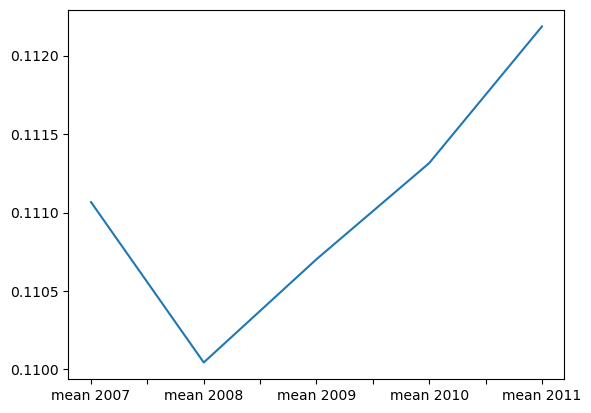

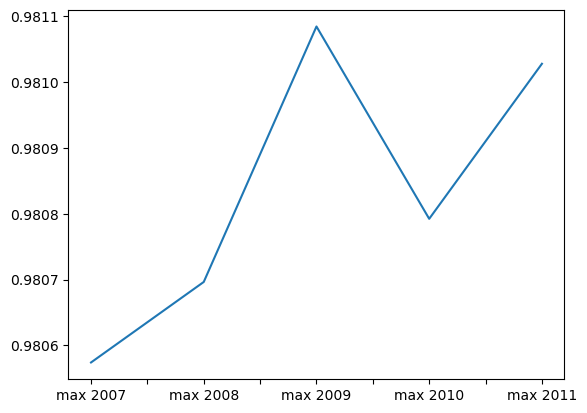

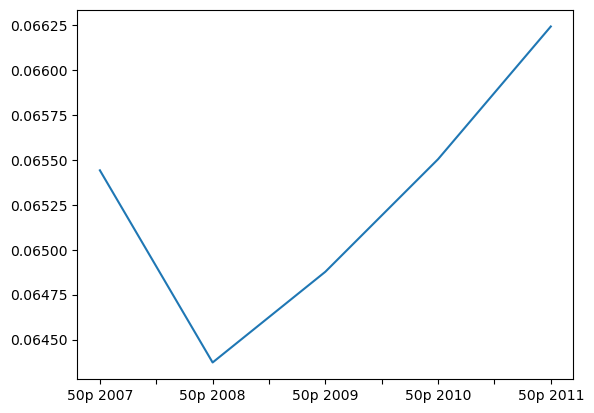

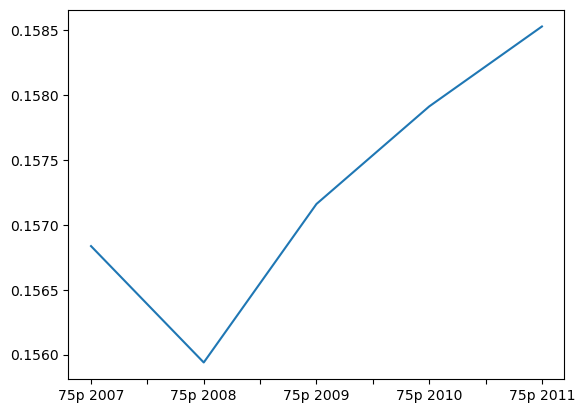

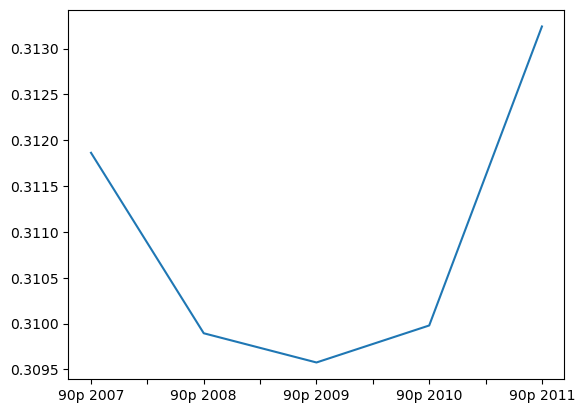

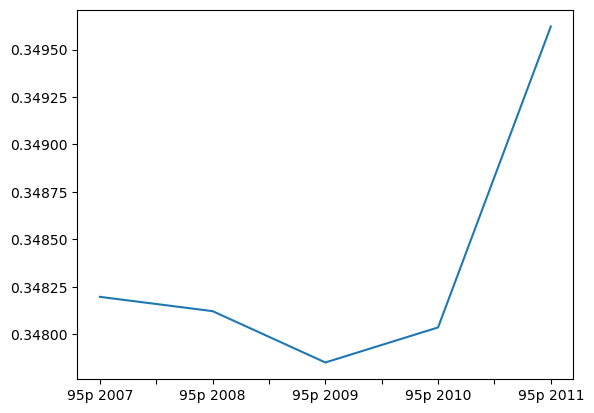

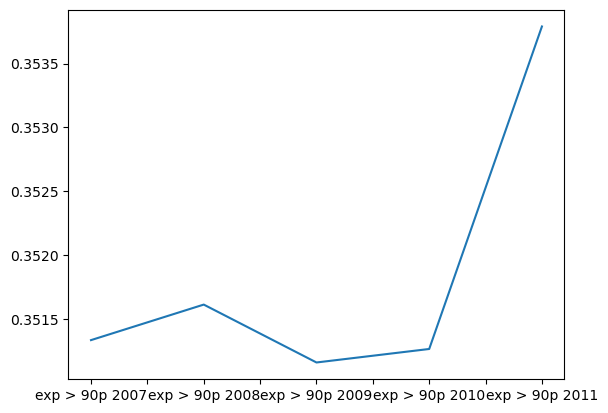

In [520]:
pd.concat(to_plot_df,axis = 1).filter(like = 'mean').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(like = 'max').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(like = '50p').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(like = '75p').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(regex = '^90p').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(like = '95p').mean().plot()
plt.show()
pd.concat(to_plot_df,axis = 1).filter(like = 'exp > 90p').mean().plot()
plt.show()

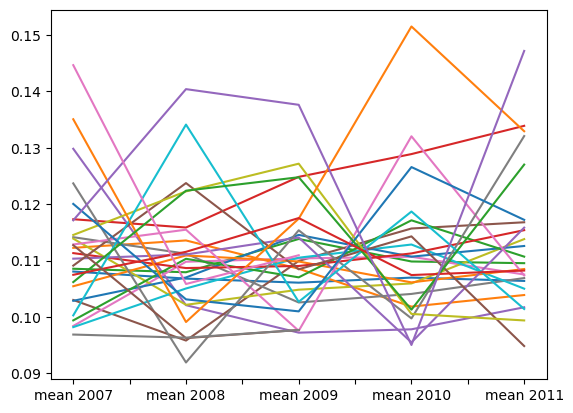

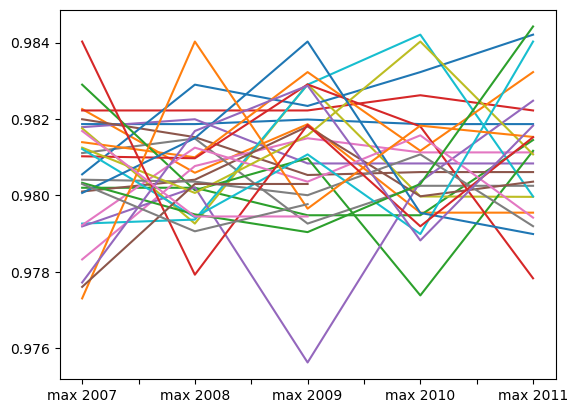

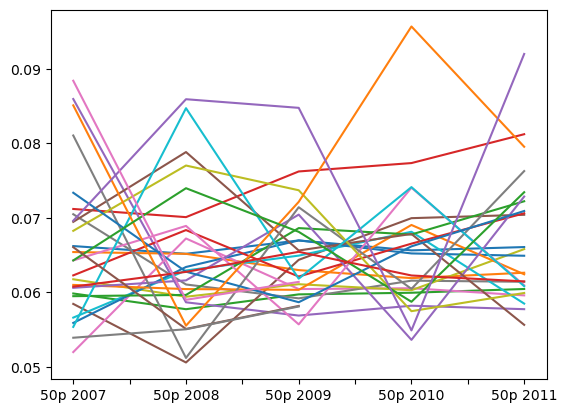

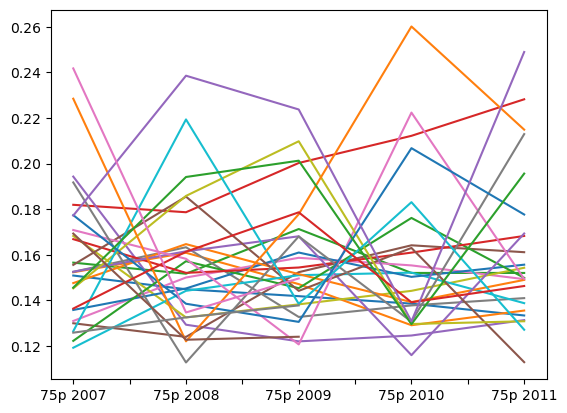

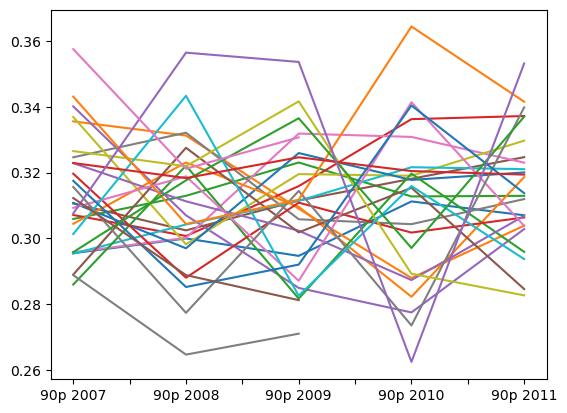

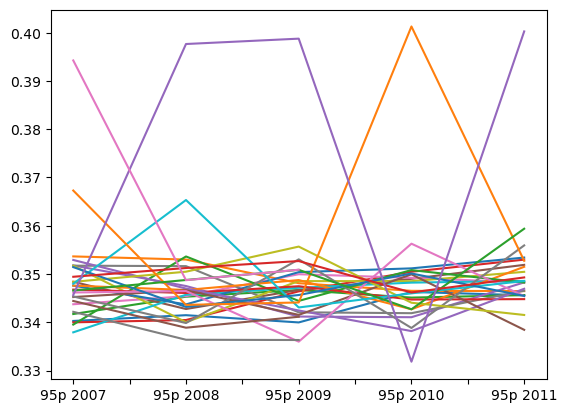

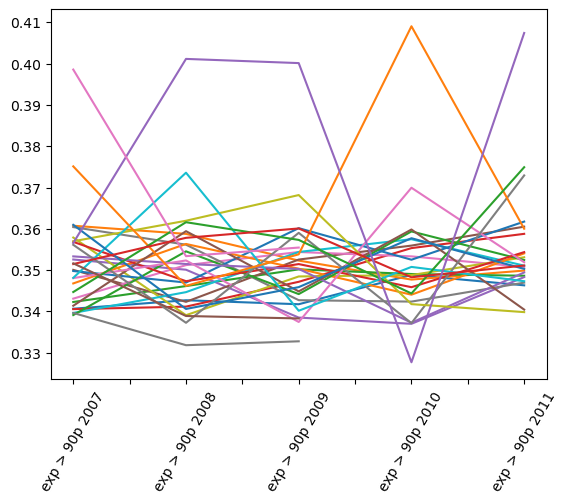

In [523]:
pd.concat(to_plot_df,axis = 1).filter(like = 'mean').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(like = 'max').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(like = '50p').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(like = '75p').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(regex = '^90p').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(like = '95p').T.plot(legend = False)
pd.concat(to_plot_df,axis = 1).filter(like = 'exp > 90p').T.plot(legend = False)
plt.xticks(rotation = 60)
plt.show()